**LIBRARIES & FUNCTIONS**

Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import json 

!pip install lxml
!pip install geopy
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium 

from IPython.display import Image
from IPython.core.display import HTML 

from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


Credentials

In [2]:
CLIENT_ID = 'FDEQATRDUJMGFTJL5SZH2M3RHIIXJ00BANMCUVBG2TB4FJ5U' # your Foursquare ID
CLIENT_SECRET = 'VV3HJAUBIL1OGJIMQZESK3T1FVDUUQMHPWCAT3PW2IXZ5SWL' # your Foursquare Secret
ACCESS_TOKEN = '4Q3LIZDIPLDM2CHKNKEEDDXV1X5MAKWF4S0T2XBNFSNGDPBK' # your FourSquare Access Token
VERSION = '20210123'
LIMIT = 100

Functions

In [3]:
# Function that extracts coordinates of location
def get_coor(district):
    address = district

    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    lat = location.latitude
    long = location.longitude
    
    data ={'District':[address],
          'Latitude':[lat],
          'Longitude':[long]}
    df = pd.DataFrame(data)
    
    return df

#Function that creates coordinate list
def get_coor_list():
    coor_list = []
    for ind in district.index:
        coor_list.append(get_coor(district['District'][ind]))
    return coor_list

# Function to get list of nearby venues
def getNearbyVenues(names, latitudes, longitudes, label, category, radius=2500):
    
    venues_list=[]
    for name, lat, lng, lbl in zip(names, latitudes, longitudes, label):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            category,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lbl,
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District',
                             'Label',
                  'District_Latitude', 
                  'District_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

# Function to get top venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

**DATA RETRIEVAL & CLEANING**

Create df of district names

In [4]:
data = {'District':[
    "Ampang",
    "Batu Caves",
    "Cheras",
    "Damansara",
    "Gombak",
    "Hulu Kelang",
    "Kepong",
    "Kuala Lumpur",
    "Petaling",
    "Petaling Jaya",
    "Sentul",
    "Setapak",
    "Sungai Besi"
    ]}

district = pd.DataFrame(data)
district.head()

District
0      Ampang
1  Batu Caves
2      Cheras
3   Damansara
4      Gombak

Create a df of districts with their coordinates

In [5]:
district_ll = get_coor_list()
dist_np = np.array(district_ll)
dist_np = dist_np.reshape(13,3)

district_list = pd.DataFrame(dist_np,columns=['District','Latitude','Longitude'])
district_list.head()

District Latitude Longitude
0      Ampang  3.15026    101.76
1  Batu Caves  3.23745   101.681
2      Cheras  3.09919   101.737
3   Damansara  3.13463   101.599
4      Gombak  3.23304   101.715

In [6]:
district_list["Latitude"] = district_list["Latitude"].astype(str).astype(float)
district_list["Longitude"] = district_list["Longitude"].astype(str).astype(float)
district_list.dtypes

District      object
Latitude     float64
Longitude    float64
dtype: object

In [7]:
# Create a column labels to label each district

# create a list of our conditions
conditions = [
    (district_list['District'] == "Ampang"),
    (district_list['District'] == "Batu Caves"),
    (district_list['District'] == "Cheras"),
    (district_list['District'] == "Damansara"),
    (district_list['District'] == "Gombak"),
    (district_list['District'] == "Hulu Kelang"),
    (district_list['District'] == "Kepong"),
    (district_list['District'] == "Kuala Lumpur"),
    (district_list['District'] == "Petaling"),
    (district_list['District'] == "Petaling Jaya"),
    (district_list['District'] == "Sentul"),
    (district_list['District'] == "Setapak"),
    (district_list['District'] == "Sungai Besi")
    ]

# create a list of the values we want to assign for each condition
values = [1,2,3,4,5,6,7,8,9,10,11,12,13]
district_list['Label']=pd.DataFrame(np.select(conditions, values))
district_list.head(15)

District  Latitude   Longitude  Label
0          Ampang  3.150256  101.760210      1
1      Batu Caves  3.237451  101.681226      2
2          Cheras  3.099192  101.737423      3
3       Damansara  3.134633  101.599019      4
4          Gombak  3.233044  101.714574      5
5     Hulu Kelang  3.209928  101.760851      6
6          Kepong  3.214029  101.634842      7
7    Kuala Lumpur  3.151696  101.694237      8
8        Petaling  3.086134  101.664207      9
9   Petaling Jaya  3.139646  101.589637     10
10         Sentul  3.178618  101.695478     11
11        Setapak  3.188615  101.710813     12
12    Sungai Besi  3.063789  101.708002     13

Get a list of nearby venues by category

*Food & Beverages Outlets*

In [8]:
category = 'Food'
venue_food = getNearbyVenues(names=district_list['District'],latitudes=district_list['Latitude'],longitudes=district_list['Longitude'],label=district_list['Label'] ,category=category)

Ampang
Batu Caves
Cheras
Damansara
Gombak
Hulu Kelang
Kepong
Kuala Lumpur
Petaling
Petaling Jaya
Sentul
Setapak
Sungai Besi


In [9]:
# Check if there were any mistakes in the category
venue_food['Venue_Category'].unique()

array(['Thai Restaurant', 'Food Truck', 'Asian Restaurant',
       'Fast Food Restaurant', 'Middle Eastern Restaurant',
       'Malay Restaurant', 'Chinese Restaurant', 'Burger Joint',
       'Pakistani Restaurant', 'Korean Restaurant', 'Halal Restaurant',
       'Indian Restaurant', 'Noodle House', 'Restaurant', 'Café',
       'Pizza Place', 'Italian Restaurant', 'Indonesian Restaurant',
       'Seafood Restaurant', 'Falafel Restaurant',
       'Vegetarian / Vegan Restaurant', 'Breakfast Spot',
       'Afghan Restaurant', 'Steakhouse', 'Mexican Restaurant', 'Bakery',
       'Fried Chicken Joint', 'Food Court', 'Japanese Restaurant',
       'Comfort Food Restaurant', 'Taiwanese Restaurant',
       'Sushi Restaurant', 'Soup Place', 'Sandwich Place', 'Diner',
       'Food Stand', 'Portuguese Restaurant', 'Bistro', 'Snack Place',
       'BBQ Joint', 'Hainan Restaurant', 'Salad Place',
       'Kebab Restaurant', 'Hotpot Restaurant', 'Food',
       'Brazilian Restaurant', 'Gastropub', 'Amer

*Healthcare Facilities*

In [10]:
category = 'Hospital'
venue_hosp = getNearbyVenues(names=district_list['District'],latitudes=district_list['Latitude'],longitudes=district_list['Longitude'],label=district_list['Label'],category=category)

Ampang
Batu Caves
Cheras
Damansara
Gombak
Hulu Kelang
Kepong
Kuala Lumpur
Petaling
Petaling Jaya
Sentul
Setapak
Sungai Besi


In [11]:
# Check if there were any mistakes in the category
venue_hosp['Venue_Category'].unique()

array(['Hospital', 'Medical Center', "Doctor's Office", 'Emergency Room',
       'Office', 'Hospital Ward', 'Pharmacy', 'Veterinarian', 'Parking',
       'Assisted Living', 'Motel', 'Temple', 'Road', 'Hotel'],
      dtype=object)

In [12]:
# Cleaning irrelevant entries
venue_hosp_clean = venue_hosp.query("Venue_Category == ('Hospital', 'Medical Center', 'Emergency Room', 'Office', 'Hospital Ward', 'Pharmacy')")
venue_hosp_clean['Venue_Category'].unique()

array(['Hospital', 'Medical Center', 'Emergency Room', 'Office',
       'Hospital Ward', 'Pharmacy'], dtype=object)

*Schools*

In [13]:
category = 'School'
venue_schl = getNearbyVenues(names=district_list['District'],latitudes=district_list['Latitude'],longitudes=district_list['Longitude'],label=district_list['Label'],category=category)

Ampang
Batu Caves
Cheras
Damansara
Gombak
Hulu Kelang
Kepong
Kuala Lumpur
Petaling
Petaling Jaya
Sentul
Setapak
Sungai Besi


In [14]:
# Check if there were any mistakes in the category
venue_schl['Venue_Category'].unique()

array(['School', 'High School', 'Private School', 'College Classroom',
       'Elementary School', 'Office', 'Church',
       'General College & University', 'Preschool', 'Nursery School',
       'Trade School', 'Student Center', 'Middle School', 'University',
       'Language School', 'Religious School', 'Music School', 'Bookstore',
       'Driving School', 'Music Venue', 'College Academic Building',
       'Adult Education Center', 'Building', 'Music Store',
       'Cosmetics Shop', 'Swim School', 'Community College',
       'Neighborhood', 'Mosque', 'College & University', 'Law School',
       'Auditorium', 'Tech Startup', 'Flea Market', 'History Museum',
       'General Travel', 'Nightclub', 'Government Building', 'Field',
       'Grocery Store', 'Record Shop', 'Theater', 'Circus School',
       'Art Museum', 'Dance Studio'], dtype=object)

In [15]:
# Cleaning irrelevant entries
venue_schl_clean = venue_schl.query("Venue_Category == ('School', 'High School', 'Private School', 'Elementary School','Preschool', 'Nursery School','Middle School')")
venue_schl_clean['Venue_Category'].unique()

array(['School', 'High School', 'Private School', 'Elementary School',
       'Preschool', 'Nursery School', 'Middle School'], dtype=object)

*Arts & Entertainment*

In [16]:
category = 'Arts & Entertainment'
venue_entr = getNearbyVenues(names=district_list['District'],latitudes=district_list['Latitude'],longitudes=district_list['Longitude'],label=district_list['Label'],category=category)

Ampang
Batu Caves
Cheras
Damansara
Gombak
Hulu Kelang
Kepong
Kuala Lumpur
Petaling
Petaling Jaya
Sentul
Setapak
Sungai Besi


In [17]:
# Check if there were any mistakes in the category
venue_entr['Venue_Category'].unique()

array(['Pharmacy', 'Café', 'Malay Restaurant', 'Korean Restaurant',
       'Arts & Crafts Store', 'Flea Market', 'Art Gallery',
       'Dance Studio', 'Music Venue', 'Fish Market', 'Office',
       'Sporting Goods Shop', 'Spa', 'Coffee Shop', 'Soccer Field',
       'Night Market', 'Supermarket', 'Bistro', 'Martial Arts School',
       'Burger Joint', 'Cosmetics Shop', 'Fast Food Restaurant',
       'Furniture / Home Store', 'Health & Beauty Service',
       'Paper / Office Supplies Store', 'Gym', 'Museum', 'University',
       'Bookstore', 'Shopping Mall', 'Science Museum',
       'Performing Arts Venue', 'History Museum', 'Train Station',
       'Chinese Restaurant', 'Multiplex', 'Bus Station', 'Hotel',
       'Tourist Information Center', 'Department Store', 'Gym Pool',
       'Event Space', 'Tunnel', 'Restaurant', 'Halal Restaurant',
       'Lounge', 'Bridge', 'Speakeasy', 'Molecular Gastronomy Restaurant',
       'Dessert Shop', 'Frame Store', 'Design Studio', 'Theater',
       'Ca

In [18]:
# Cleaning irrelevant entries
venue_entr_clean = venue_entr.query("Venue_Category == ('Arts & Crafts Store', 'Art Gallery', 'Dance Studio', 'Music Venue','Spa', 'Soccer Field','Gym','Museum','Science Museum','History Museum','Gym Pool','Theater','Art Museum','Soccer Stadium')")
venue_entr_clean['Venue_Category'].unique()

array(['Arts & Crafts Store', 'Art Gallery', 'Dance Studio',
       'Music Venue', 'Spa', 'Soccer Field', 'Gym', 'Museum',
       'Science Museum', 'History Museum', 'Gym Pool', 'Theater',
       'Art Museum', 'Soccer Stadium'], dtype=object)

**Data Analysis**

Data Visualisation

Visualise the location of each district

In [19]:
map_kl = folium.Map(location=[3.151696, 101.694237], zoom_start=12)

# add markers to map
for lat, lng,name in zip(district_list['Latitude'], district_list['Longitude'], district_list['District']):
        label = '{}'.format(name)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=4,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_kl)  
map_kl

In [20]:
# In case github is unable to print follium map
Image(url= "https://raw.githubusercontent.com/tylerhys/capstone/tylerhys-SCNSHOTS/map_kl.PNG")

In [21]:
x = np.arange(13)
ys = [i + x + (i*x)**2 for i in range(13)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

Visualise food & beverages outlets

In [22]:
map_food = folium.Map(location=[3.151696, 101.694237], zoom_start=12)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venue_food['Venue_Latitude'], venue_food['Venue_Longitude'], venue_food['Venue'], venue_food['Label']):
        label = '{}'.format(poi)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_food)
        
for lat, lng,name, cluster in zip(district_list['Latitude'], district_list['Longitude'], district_list['District'],district_list['Label']):
        label = '{}'.format(name)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='black',
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7,
            parse_html=False).add_to(map_food) 
folium.TileLayer('cartodbpositron').add_to(map_food)
map_food

In [23]:
# In case github is unable to print follium map
Image(url= "https://raw.githubusercontent.com/tylerhys/capstone/tylerhys-SCNSHOTS/map_food.PNG")

Visualise healthcare facilities

In [24]:
map_hosp = folium.Map(location=[3.151696, 101.694237], zoom_start=12)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venue_hosp_clean['Venue_Latitude'], venue_hosp_clean['Venue_Longitude'], venue_hosp_clean['Venue'], venue_hosp_clean['Label']):
        label = '{}'.format(poi)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_hosp)
        
for lat, lng,name, cluster in zip(district_list['Latitude'], district_list['Longitude'], district_list['District'],district_list['Label']):
        label = '{}'.format(name)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='black',
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7,
            parse_html=False).add_to(map_hosp) 
folium.TileLayer('cartodbpositron').add_to(map_hosp)
map_hosp

In [25]:
# In case github is unable to print follium map
Image(url= "https://raw.githubusercontent.com/tylerhys/capstone/tylerhys-SCNSHOTS/map_hosp.PNG")

Visualise schools

In [26]:
map_schl = folium.Map(location=[3.151696, 101.694237], zoom_start=12)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venue_schl_clean['Venue_Latitude'], venue_schl_clean['Venue_Longitude'], venue_schl_clean['Venue'], venue_schl_clean['Label']):
        label = '{}'.format(poi)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_schl)
        
for lat, lng,name, cluster in zip(district_list['Latitude'], district_list['Longitude'], district_list['District'],district_list['Label']):
        label = '{}'.format(name)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='black',
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7,
            parse_html=False).add_to(map_schl) 
folium.TileLayer('cartodbpositron').add_to(map_schl)
map_schl

In [27]:
# In case github is unable to print follium map
Image(url= "https://raw.githubusercontent.com/tylerhys/capstone/tylerhys-SCNSHOTS/map_schl.PNG")

Visualise Art & Entertainment Venues

In [28]:
map_entr = folium.Map(location=[3.151696, 101.694237], zoom_start=12)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venue_entr_clean['Venue_Latitude'], venue_entr_clean['Venue_Longitude'], venue_entr_clean['Venue'], venue_entr_clean['Label']):
        label = '{}'.format(poi)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_entr)
        
for lat, lng,name, cluster in zip(district_list['Latitude'], district_list['Longitude'], district_list['District'],district_list['Label']):
        label = '{}'.format(name)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='black',
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7,
            parse_html=False).add_to(map_entr) 
folium.TileLayer('cartodbpositron').add_to(map_entr)
map_entr

In [29]:
# In case github is unable to print follium map
Image(url= "https://raw.githubusercontent.com/tylerhys/capstone/tylerhys-SCNSHOTS/map_entr.PNG")

More Data Visualisation

*Food & Beverages Outlets*

In [30]:
# one hot encoding
f_onehot = pd.get_dummies(venue_food[['Venue_Category']], prefix="", prefix_sep="")

# add district column back to dataframe
f_onehot['District'] = venue_food['District'] 

# move district column to the first column
fixed_columns = [f_onehot.columns[-1]] + list(f_onehot.columns[:-1])
f_onehot = f_onehot[fixed_columns]

f_onehot.head()

District  Afghan Restaurant  American Restaurant  Asian Restaurant  \
0   Ampang                  0                    0                 0   
1   Ampang                  0                    0                 0   
2   Ampang                  0                    0                 1   
3   Ampang                  0                    0                 0   
4   Ampang                  0                    0                 0   

   BBQ Joint  Bakery  Bistro  Brazilian Restaurant  Breakfast Spot  \
0          0       0       0                     0               0   
1          0       0       0                     0               0   
2          0       0       0                     0               0   
3          0       0       0                     0               0   
4          0       0       0                     0               0   

   Burger Joint  ...  Steakhouse  Sushi Restaurant  Szechuan Restaurant  \
0             0  ...           0                 0                    0   
1             0  ...           0                 0                    0   
2             0  ...           0                 0                    0   
3             0  ...           0                 0                    0   
4             0  ...           0                 0                    0   

   Taiwanese Restaurant  Tapas Restaurant  Thai Restaurant  Udon Restaurant  \
0                     0                 0                1                0   
1                     0                 0                0                0   
2                     0                 0                0                0   
3                     0                 0                0                0   
4                     0                 0                0                0   

   Vegetarian / Vegan Restaurant  Wings Joint  Yakitori Restaurant  
0                              0            0                    0  
1                              0            0                    0  
2                              0            0                    0  
3                              0            0                    0  
4                              0            0                    0  

[5 rows x 76 columns]

In [31]:
venue_food['Venue_Category'].unique()

array(['Thai Restaurant', 'Food Truck', 'Asian Restaurant',
       'Fast Food Restaurant', 'Middle Eastern Restaurant',
       'Malay Restaurant', 'Chinese Restaurant', 'Burger Joint',
       'Pakistani Restaurant', 'Korean Restaurant', 'Halal Restaurant',
       'Indian Restaurant', 'Noodle House', 'Restaurant', 'Café',
       'Pizza Place', 'Italian Restaurant', 'Indonesian Restaurant',
       'Seafood Restaurant', 'Falafel Restaurant',
       'Vegetarian / Vegan Restaurant', 'Breakfast Spot',
       'Afghan Restaurant', 'Steakhouse', 'Mexican Restaurant', 'Bakery',
       'Fried Chicken Joint', 'Food Court', 'Japanese Restaurant',
       'Comfort Food Restaurant', 'Taiwanese Restaurant',
       'Sushi Restaurant', 'Soup Place', 'Sandwich Place', 'Diner',
       'Food Stand', 'Portuguese Restaurant', 'Bistro', 'Snack Place',
       'BBQ Joint', 'Hainan Restaurant', 'Salad Place',
       'Kebab Restaurant', 'Hotpot Restaurant', 'Food',
       'Brazilian Restaurant', 'Gastropub', 'Amer

In [32]:
df_f = f_onehot.groupby(by="District").sum()

df_f["Chinese Food"]=sum([df_f['Chinese Restaurant'],df_f["Seafood Restaurant"],df_f['Noodle House'],df_f['Taiwanese Restaurant'],df_f['Soup Place'],df_f['Hainan Restaurant'],df_f['Hotpot Restaurant'],df_f['Szechuan Restaurant'],df_f['Cantonese Restaurant'],df_f['Hakka Restaurant'],df_f['Dim Sum Restaurant'],df_f['Hunan Restaurant'],df_f['Hong Kong Restaurant'],df_f['Chinese Breakfast Place'],df_f['Dumpling Restaurant']])
df_f["Malay Food"]=sum([df_f['Malay Restaurant'],df_f['Halal Restaurant'],df_f["Satay Restaurant"]])
df_f["Indian Food"]=sum([df_f['Indian Restaurant'],df_f['South Indian Restaurant'],df_f["Chettinad Restaurant"],df_f["Mamak Restaurant"]])
df_f["Food Court"]=sum([df_f['Food Court'],df_f["Cafeteria"]])
df_f["Japanese Food"]=sum([df_f['Japanese Restaurant'],df_f["Sushi Restaurant"],df_f['Yakitori Restaurant'],df_f['Udon Restaurant'],df_f['Ramen Restaurant']])
df_f["Other Asian Food"]=sum([df_f['Thai Restaurant'],df_f['Asian Restaurant'],df_f['Pakistani Restaurant'],df_f['Korean Restaurant'],df_f['Afghan Restaurant'],df_f['Portuguese Restaurant'],df_f['BBQ Joint']])
df_f["Western Food"]=sum([df_f['Pizza Place'],df_f["Italian Restaurant"],df_f['Breakfast Spot'],df_f['Steakhouse'],df_f['Mexican Restaurant'],df_f['Diner'],df_f['American Restaurant'],df_f['Fish & Chips Shop'],df_f['Brazilian Restaurant'],df_f['Eastern European Restaurant'],df_f['Latin American Restaurant'],df_f['Spanish Restaurant'],df_f['French Restaurant']])
df_f["Fast Food"]=sum([df_f['Food Truck'],df_f['Fast Food Restaurant'],df_f['Burger Joint'],df_f['Fried Chicken Joint'],df_f['Sandwich Place'],df_f['Food Stand'],df_f['Snack Place'],df_f['Wings Joint']])
df_f["Bakery"]=sum([df_f['Bakery'],df_f["Donut Shop"]])
df_f["Cafés"]=sum([df_f['Café'],df_f["Pet Café"]])
df_f["Vegetarian Food"]=sum([df_f['Vegetarian / Vegan Restaurant'],df_f["Salad Place"]])
df_f["Others"]=sum([df_f['Middle Eastern Restaurant'],df_f['Restaurant'],df_f["Indonesian Restaurant"],df_f["Falafel Restaurant"],df_f['Comfort Food Restaurant'],df_f["Kebab Restaurant"],df_f["Food"],df_f["Tapas Restaurant"],df_f['Iraqi Restaurant'],df_f['Moroccan Restaurant'],df_f['Bistro'],df_f["Gastropub"]])


df_f = df_f[["Chinese Food","Malay Food","Indian Food","Food Court","Japanese Food","Other Asian Food","Western Food","Fast Food","Bakery","Cafés","Vegetarian Food","Others"]]
df_f.head()

Chinese Food  Malay Food  Indian Food  Food Court  Japanese Food  \
District                                                                       
Ampang                18          16            3           2              2   
Batu Caves            18          22            9           2              2   
Cheras                45           6            2           1              3   
Damansara             18           3            1           0              4   
Gombak                12          23            2           2              2   

            Other Asian Food  Western Food  Fast Food  Bakery  Cafés  \
District                                                               
Ampang                    23            10          6       1      5   
Batu Caves                17             8         13       0      2   
Cheras                    16             5          5       1      8   
Damansara                 13            12         15       5     18   
Gombak                    16             7         15       3      4   

            Vegetarian Food  Others  
District                             
Ampang                    2      12  
Batu Caves                2       5  
Cheras                    3       5  
Damansara                 1      10  
Gombak                    1      13

<AxesSubplot:title={'center':'Type of F&B Outlets in Ampang'}, xlabel='F&B Outlets', ylabel='Number of F&B Outlets'>

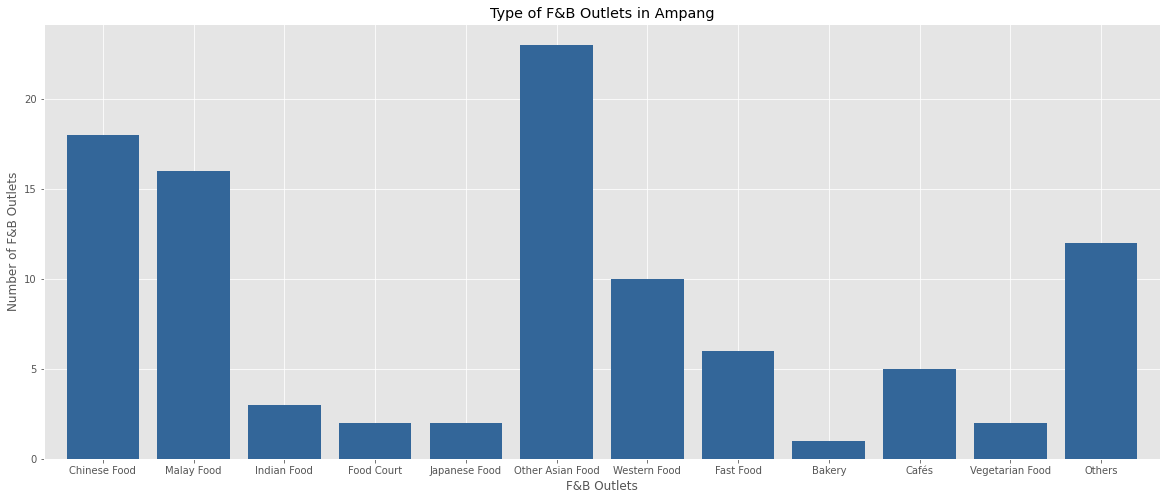

In [33]:
dist1 = df_f.loc['Ampang',:]
dist1.plot.bar(title='Type of F&B Outlets in Ampang',xlabel='F&B Outlets',ylabel='Number of F&B Outlets',rot=0,figsize=(20,8),width=0.8,color=(0.2, 0.4, 0.6))

<AxesSubplot:title={'center':'Type of F&B Outlets in Batu Caves'}, xlabel='F&B Outlets', ylabel='Number of F&B Outlets'>

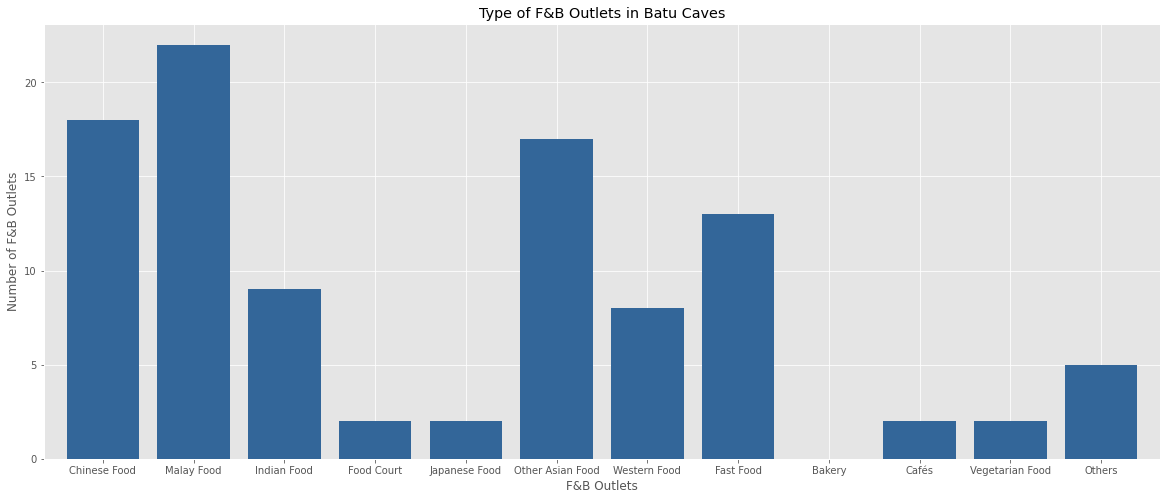

In [34]:
dist2 = df_f.loc['Batu Caves',:]
dist2.plot.bar(title='Type of F&B Outlets in Batu Caves',xlabel='F&B Outlets',ylabel='Number of F&B Outlets',rot=0,figsize=(20,8),width=0.8,color=(0.2, 0.4, 0.6))

<AxesSubplot:title={'center':'Type of F&B Outlets in Cheras'}, xlabel='F&B Outlets', ylabel='Number of F&B Outlets'>

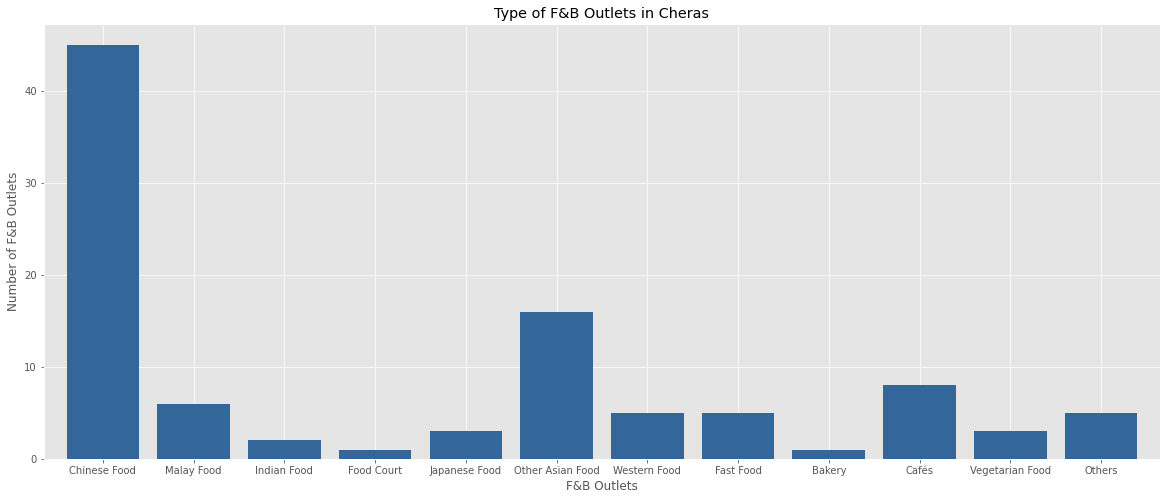

In [35]:
dist3 = df_f.loc['Cheras',:]
dist3.plot.bar(title='Type of F&B Outlets in Cheras',xlabel='F&B Outlets',ylabel='Number of F&B Outlets',rot=0,figsize=(20,8),width=0.8,color=(0.2, 0.4, 0.6))

<AxesSubplot:title={'center':'Type of F&B Outlets in Damansara'}, xlabel='F&B Outlets', ylabel='Number of F&B Outlets'>

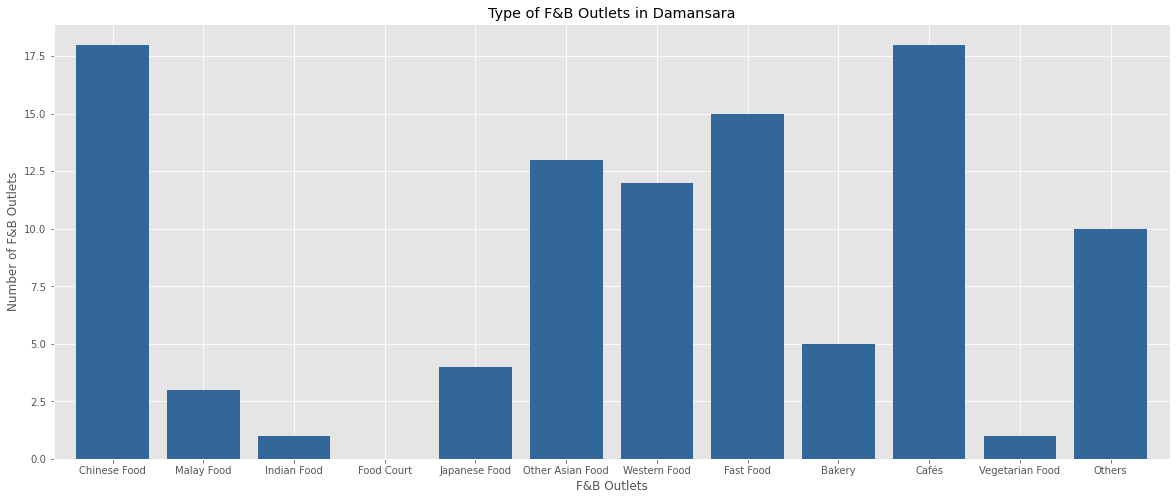

In [36]:
dist4 = df_f.loc['Damansara',:]
dist4.plot.bar(title='Type of F&B Outlets in Damansara',xlabel='F&B Outlets',ylabel='Number of F&B Outlets',rot=0,figsize=(20,8),width=0.8,color=(0.2, 0.4, 0.6))

<AxesSubplot:title={'center':'Type of F&B Outlets in Gombak'}, xlabel='F&B Outlets', ylabel='Number of F&B Outlets'>

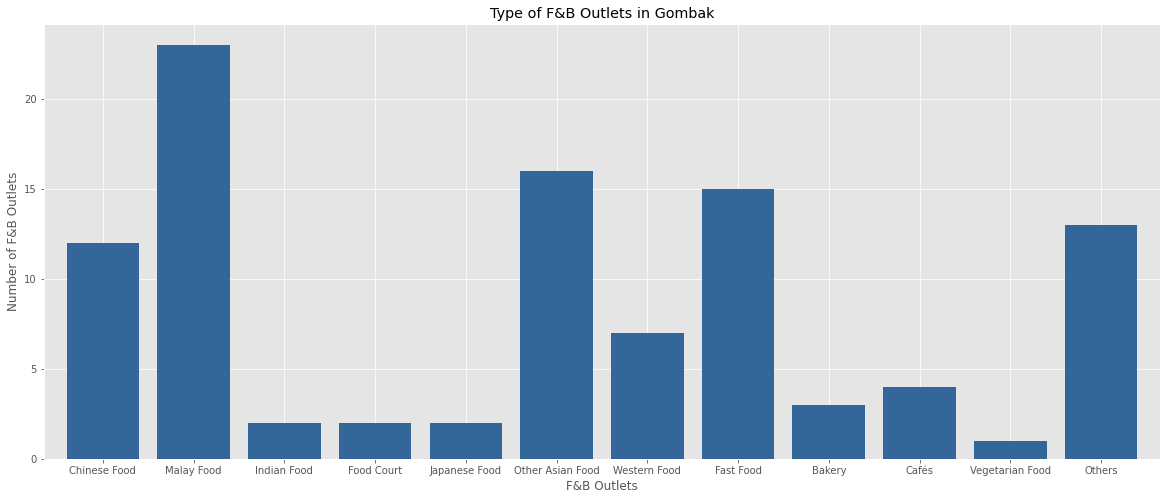

In [37]:
dist5 = df_f.loc['Gombak',:]
dist5.plot.bar(title='Type of F&B Outlets in Gombak',xlabel='F&B Outlets',ylabel='Number of F&B Outlets',rot=0,figsize=(20,8),width=0.8,color=(0.2, 0.4, 0.6))

<AxesSubplot:title={'center':'Type of F&B Outlets in Hulu Kelang'}, xlabel='F&B Outlets', ylabel='Number of F&B Outlets'>

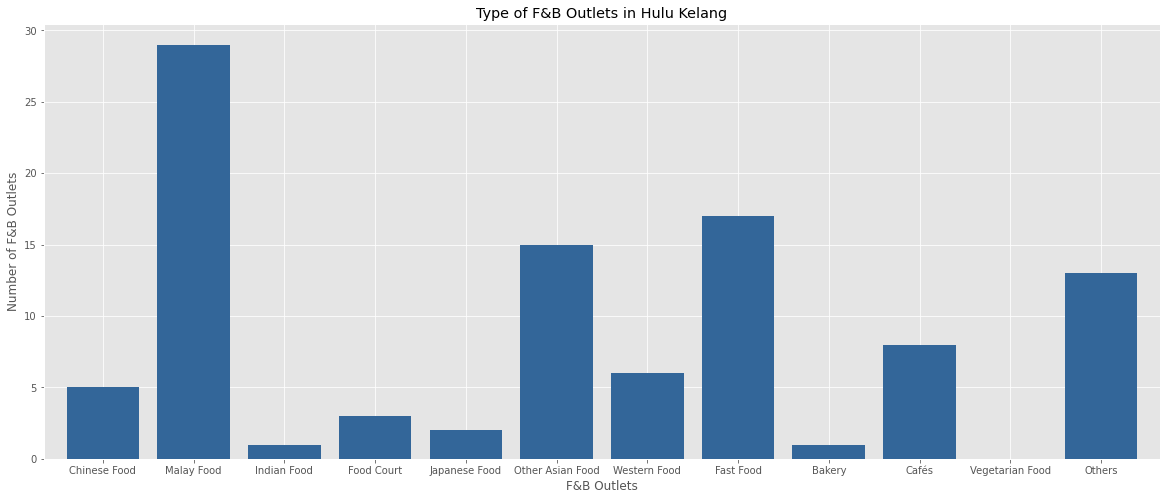

In [38]:
dist6 = df_f.loc['Hulu Kelang',:]
dist6.plot.bar(title='Type of F&B Outlets in Hulu Kelang',xlabel='F&B Outlets',ylabel='Number of F&B Outlets',rot=0,figsize=(20,8),width=0.8,color=(0.2, 0.4, 0.6))

<AxesSubplot:title={'center':'Type of F&B Outlets in Kepong'}, xlabel='F&B Outlets', ylabel='Number of F&B Outlets'>

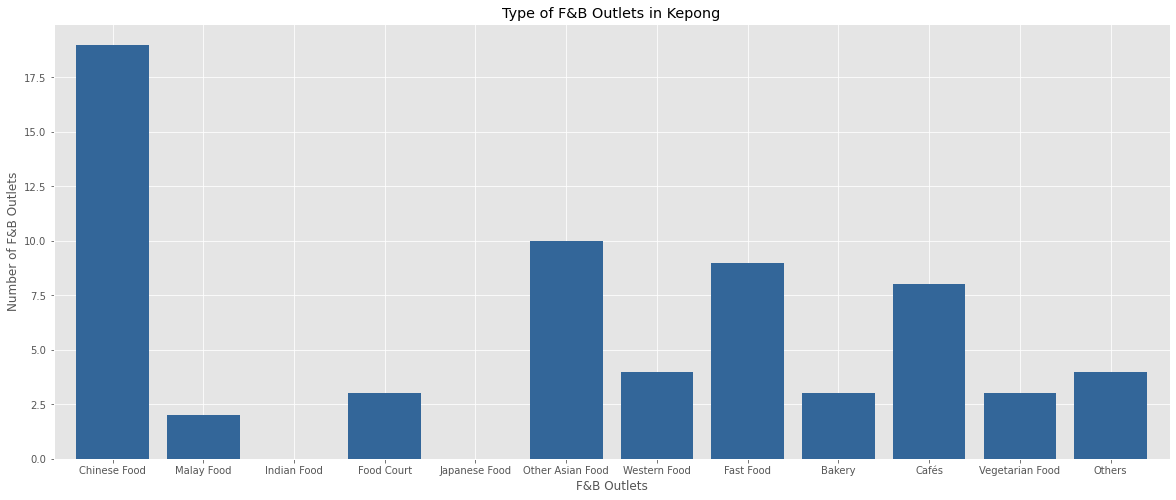

In [39]:
dist7 = df_f.loc['Kepong',:]
dist7.plot.bar(title='Type of F&B Outlets in Kepong',xlabel='F&B Outlets',ylabel='Number of F&B Outlets',rot=0,figsize=(20,8),width=0.8,color=(0.2, 0.4, 0.6))

<AxesSubplot:title={'center':'Type of F&B Outlets in Kuala Lumpur'}, xlabel='F&B Outlets', ylabel='Number of F&B Outlets'>

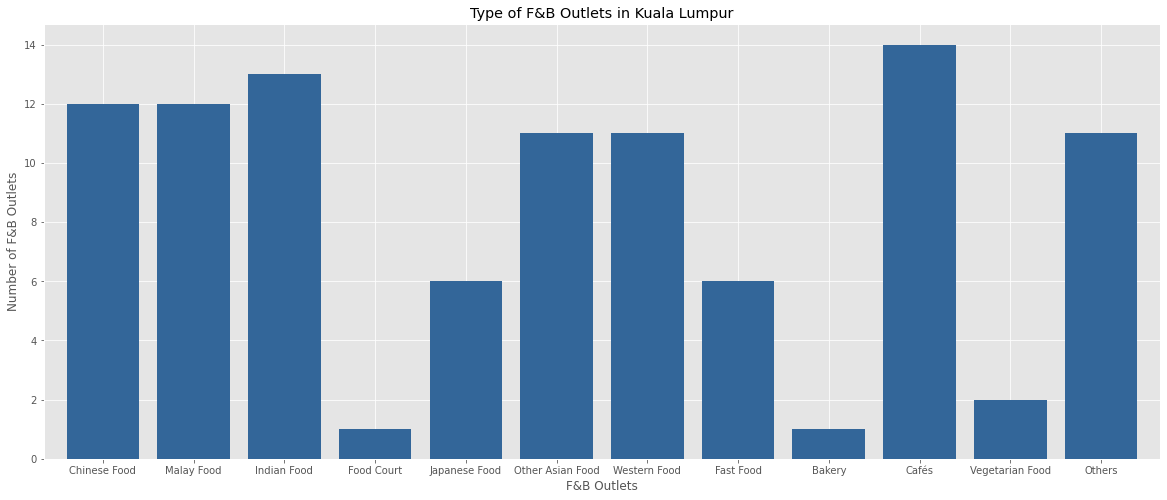

In [40]:
dist8 = df_f.loc['Kuala Lumpur',:]
dist8.plot.bar(title='Type of F&B Outlets in Kuala Lumpur',xlabel='F&B Outlets',ylabel='Number of F&B Outlets',rot=0,figsize=(20,8),width=0.8,color=(0.2, 0.4, 0.6))

<AxesSubplot:title={'center':'Type of F&B Outlets in Petaling'}, xlabel='F&B Outlets', ylabel='Number of F&B Outlets'>

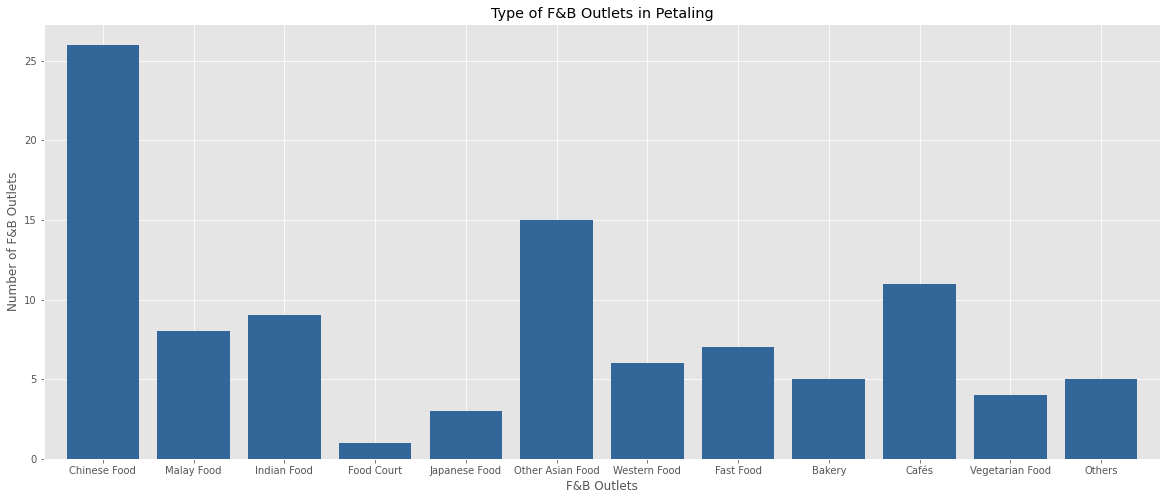

In [41]:
dist9 = df_f.loc['Petaling',:]
dist9.plot.bar(title='Type of F&B Outlets in Petaling',xlabel='F&B Outlets',ylabel='Number of F&B Outlets',rot=0,figsize=(20,8),width=0.8,color=(0.2, 0.4, 0.6))

<AxesSubplot:title={'center':'Type of F&B Outlets in Petaling Jaya'}, xlabel='F&B Outlets', ylabel='Number of F&B Outlets'>

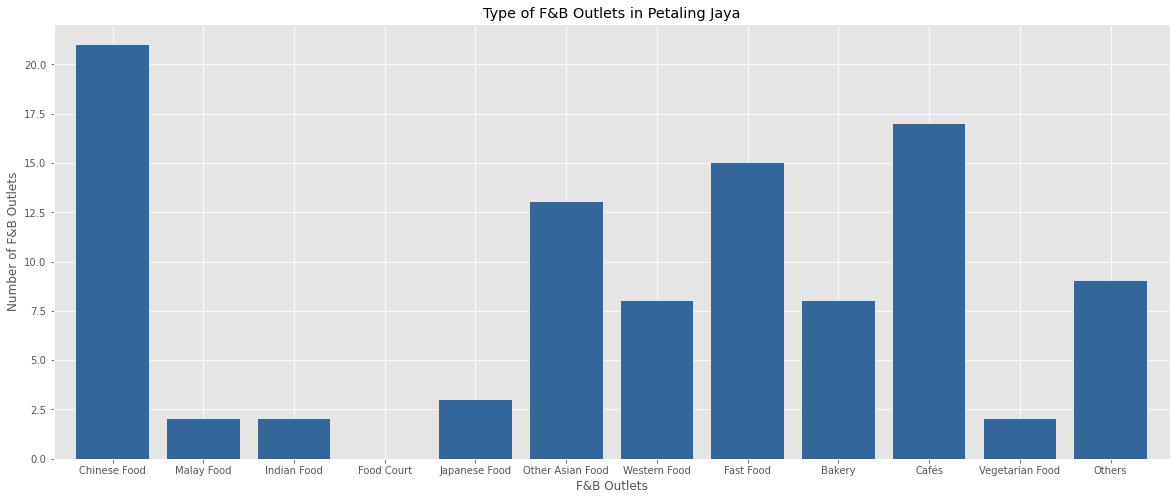

In [42]:
dist10 = df_f.loc['Petaling Jaya',:]
dist10.plot.bar(title='Type of F&B Outlets in Petaling Jaya',xlabel='F&B Outlets',ylabel='Number of F&B Outlets',rot=0,figsize=(20,8),width=0.8,color=(0.2, 0.4, 0.6))

<AxesSubplot:title={'center':'Type of F&B Outlets in Sentul'}, xlabel='F&B Outlets', ylabel='Number of F&B Outlets'>

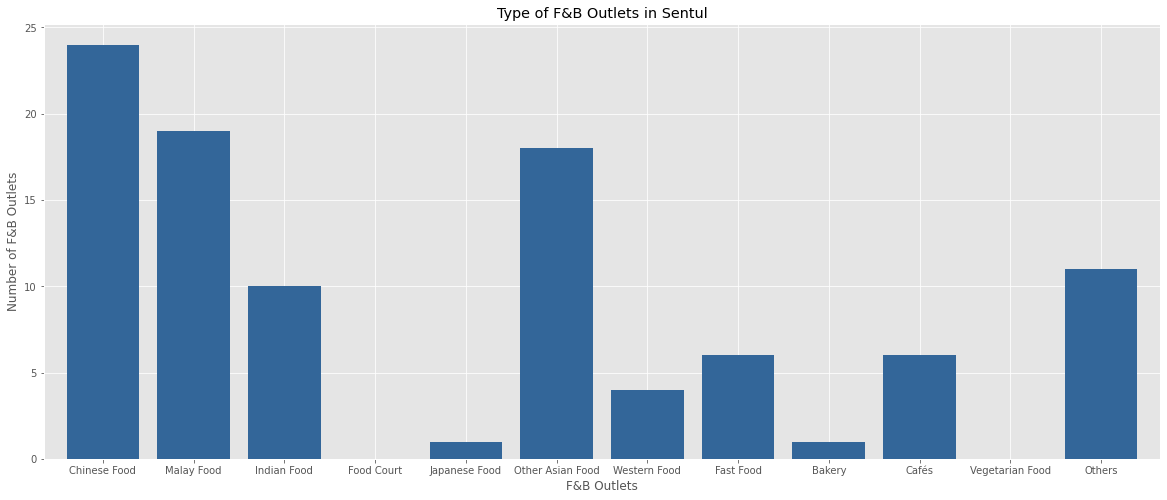

In [43]:
dist11 = df_f.loc['Sentul',:]
dist11.plot.bar(title='Type of F&B Outlets in Sentul',xlabel='F&B Outlets',ylabel='Number of F&B Outlets',rot=0,figsize=(20,8),width=0.8,color=(0.2, 0.4, 0.6))

<AxesSubplot:title={'center':'Type of F&B Outlets in Setapak'}, xlabel='F&B Outlets', ylabel='Number of F&B Outlets'>

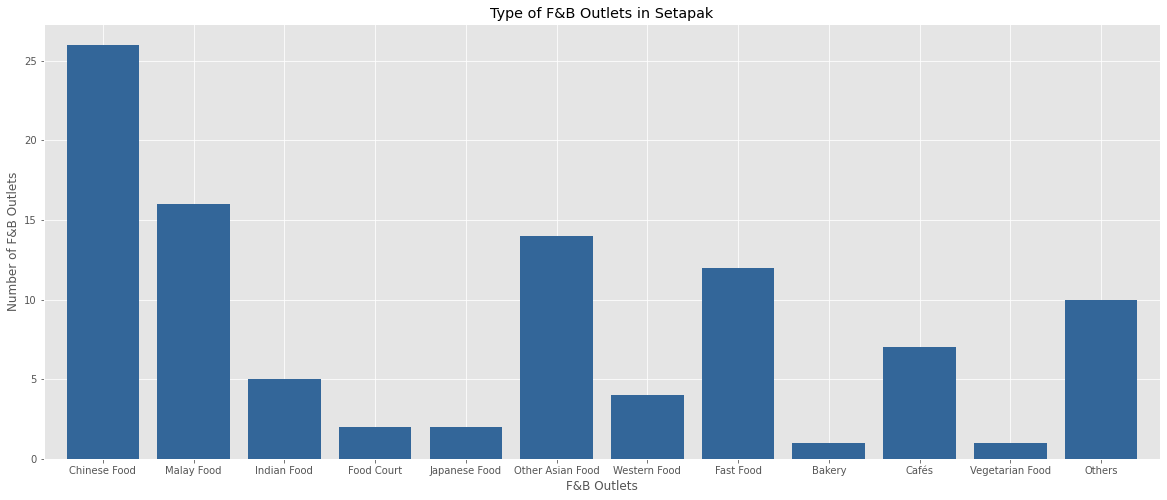

In [44]:
dist12 = df_f.loc['Setapak',:]
dist12.plot.bar(title='Type of F&B Outlets in Setapak',xlabel='F&B Outlets',ylabel='Number of F&B Outlets',rot=0,figsize=(20,8),width=0.8,color=(0.2, 0.4, 0.6))

<AxesSubplot:title={'center':'Type of F&B Outlets in Sungai Besi'}, xlabel='F&B Outlets', ylabel='Number of F&B Outlets'>

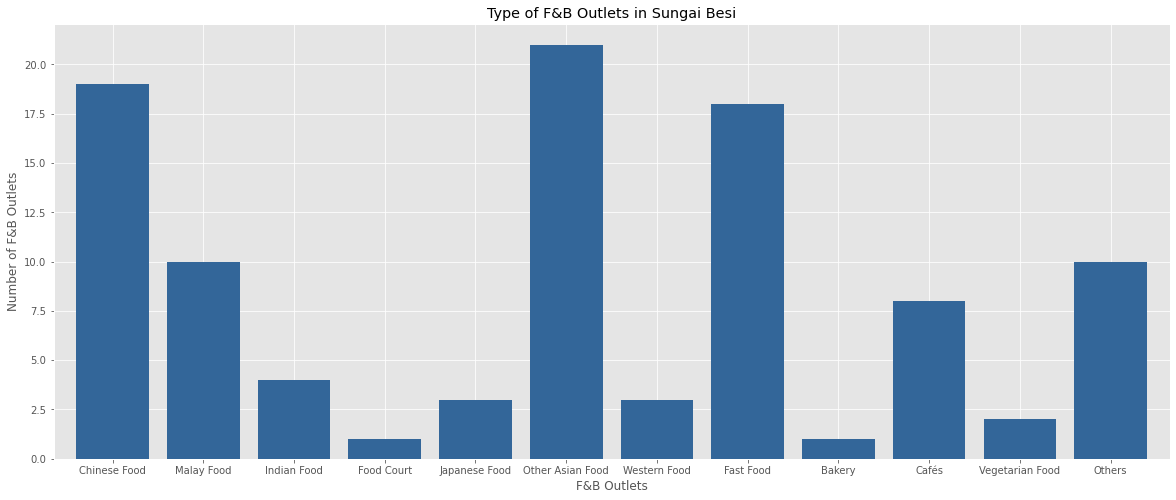

In [45]:
dist13 = df_f.loc['Sungai Besi',:]
dist13.plot.bar(title='Type of F&B Outlets in Sungai Besi',xlabel='F&B Outlets',ylabel='Number of F&B Outlets',rot=0,figsize=(20,8),width=0.8,color=(0.2, 0.4, 0.6))

*Food Clusters*

In [46]:
df_f2 = df_f.reset_index(drop=False)
df_f2.drop(columns={'Others','Other Asian Food'},inplace=True)
df_f2.head()

District  Chinese Food  Malay Food  Indian Food  Food Court  \
0      Ampang            18          16            3           2   
1  Batu Caves            18          22            9           2   
2      Cheras            45           6            2           1   
3   Damansara            18           3            1           0   
4      Gombak            12          23            2           2   

   Japanese Food  Western Food  Fast Food  Bakery  Cafés  Vegetarian Food  
0              2            10          6       1      5                2  
1              2             8         13       0      2                2  
2              3             5          5       1      8                3  
3              4            12         15       5     18                1  
4              2             7         15       3      4                1

In [47]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Highest Number of F&B Venues'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Highest Number of F&B Venues'.format(ind+1))

# create a new dataframe
df_f_sorted2 = pd.DataFrame(columns=columns)
df_f_sorted2['District'] = df_f2['District']

for ind in np.arange(df_f2.shape[0]):
    df_f_sorted2.iloc[ind, 1:] = return_most_common_venues(df_f2.iloc[ind, :], num_top_venues)
    
df_f_sorted2.head()

District 1st Highest Number of F&B Venues  \
0      Ampang                     Chinese Food   
1  Batu Caves                       Malay Food   
2      Cheras                     Chinese Food   
3   Damansara                            Cafés   
4      Gombak                       Malay Food   

  2nd Highest Number of F&B Venues 3rd Highest Number of F&B Venues  \
0                       Malay Food                     Western Food   
1                     Chinese Food                        Fast Food   
2                            Cafés                       Malay Food   
3                     Chinese Food                        Fast Food   
4                        Fast Food                     Chinese Food   

  4th Highest Number of F&B Venues 5th Highest Number of F&B Venues  
0                        Fast Food                            Cafés  
1                      Indian Food                     Western Food  
2                        Fast Food                     Western Food  
3                     Western Food                           Bakery  
4                     Western Food                            Cafés

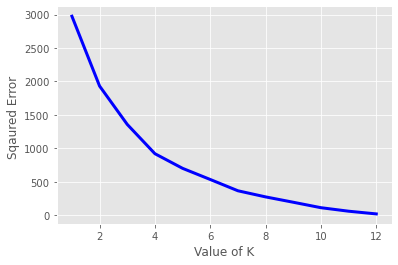

In [49]:
#Determine Bests K for clustering
df_cluster = df_f2.drop('District', 1)
x =[] 
for i in range(1, 13): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(df_cluster) 
      
    # calculates squared error 
    # for the clustered points 
    x.append(KM.inertia_)      
  
#plot the cost against K values 
plt.plot(range(1, 13), x, color ='b', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error ") 
plt.show() # clear the plot 

#Slight elbow point at k=4

In [50]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 2, 0, 1, 1, 0, 3, 0, 0], dtype=int32)

In [51]:
# add clustering labels
df_f_sorted2.insert(0, 'Cluster Labels', kmeans.labels_)

df_f_merged = district_list

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
df_f_merged = df_f_merged.join(df_f_sorted2.set_index('District'), on='District')
df_f_merged.drop(columns='Label',inplace=True)
df_f_merged.head()

District  Latitude   Longitude  Cluster Labels  \
0      Ampang  3.150256  101.760210               3   
1  Batu Caves  3.237451  101.681226               3   
2      Cheras  3.099192  101.737423               2   
3   Damansara  3.134633  101.599019               0   
4      Gombak  3.233044  101.714574               1   

  1st Highest Number of F&B Venues 2nd Highest Number of F&B Venues  \
0                     Chinese Food                       Malay Food   
1                       Malay Food                     Chinese Food   
2                     Chinese Food                            Cafés   
3                            Cafés                     Chinese Food   
4                       Malay Food                        Fast Food   

  3rd Highest Number of F&B Venues 4th Highest Number of F&B Venues  \
0                     Western Food                        Fast Food   
1                        Fast Food                      Indian Food   
2                       Malay Food                        Fast Food   
3                        Fast Food                     Western Food   
4                     Chinese Food                     Western Food   

  5th Highest Number of F&B Venues  
0                            Cafés  
1                     Western Food  
2                     Western Food  
3                           Bakery  
4                            Cafés

In [52]:
# create map
map_clusters = folium.Map(location=[3.151696, 101.694237], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_f_merged['Latitude'], df_f_merged['Longitude'], df_f_merged['District'], df_f_merged['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.TileLayer('cartodbpositron').add_to(map_clusters)       
map_clusters

In [53]:
# In case github is unable to print follium map
Image(url= "https://raw.githubusercontent.com/tylerhys/capstone/tylerhys-SCNSHOTS/cluster_map.PNG")

Examine the Clusters

Cluster 1

In [54]:
df_f_merged.loc[df_f_merged['Cluster Labels'] == 0, df_f_merged.columns[[0] + list(range(4, df_f_merged.shape[1]))]]

District 1st Highest Number of F&B Venues  \
3       Damansara                            Cafés   
6          Kepong                     Chinese Food   
8        Petaling                     Chinese Food   
9   Petaling Jaya                     Chinese Food   
12    Sungai Besi                     Chinese Food   

   2nd Highest Number of F&B Venues 3rd Highest Number of F&B Venues  \
3                      Chinese Food                        Fast Food   
6                         Fast Food                            Cafés   
8                             Cafés                      Indian Food   
9                             Cafés                        Fast Food   
12                        Fast Food                       Malay Food   

   4th Highest Number of F&B Venues 5th Highest Number of F&B Venues  
3                      Western Food                           Bakery  
6                      Western Food                  Vegetarian Food  
8                        Malay Food                        Fast Food  
9                            Bakery                     Western Food  
12                            Cafés                      Indian Food

Cluster 2

In [55]:
df_f_merged.loc[df_f_merged['Cluster Labels'] == 1, df_f_merged.columns[[0] + list(range(4, df_f_merged.shape[1]))]]

District 1st Highest Number of F&B Venues  \
4       Gombak                       Malay Food   
5  Hulu Kelang                       Malay Food   

  2nd Highest Number of F&B Venues 3rd Highest Number of F&B Venues  \
4                        Fast Food                     Chinese Food   
5                        Fast Food                            Cafés   

  4th Highest Number of F&B Venues 5th Highest Number of F&B Venues  
4                     Western Food                            Cafés  
5                     Western Food                     Chinese Food

Cluster 3

In [56]:
df_f_merged.loc[df_f_merged['Cluster Labels'] == 2, df_f_merged.columns[[0] + list(range(4, df_f_merged.shape[1]))]]

District 1st Highest Number of F&B Venues 2nd Highest Number of F&B Venues  \
2   Cheras                     Chinese Food                            Cafés   

  3rd Highest Number of F&B Venues 4th Highest Number of F&B Venues  \
2                       Malay Food                        Fast Food   

  5th Highest Number of F&B Venues  
2                     Western Food

Cluster 4

In [57]:
df_f_merged.loc[df_f_merged['Cluster Labels'] == 3, df_f_merged.columns[[0] + list(range(4, df_f_merged.shape[1]))]]

District 1st Highest Number of F&B Venues  \
0         Ampang                     Chinese Food   
1     Batu Caves                       Malay Food   
7   Kuala Lumpur                            Cafés   
10        Sentul                     Chinese Food   
11       Setapak                     Chinese Food   

   2nd Highest Number of F&B Venues 3rd Highest Number of F&B Venues  \
0                        Malay Food                     Western Food   
1                      Chinese Food                        Fast Food   
7                       Indian Food                       Malay Food   
10                       Malay Food                      Indian Food   
11                       Malay Food                        Fast Food   

   4th Highest Number of F&B Venues 5th Highest Number of F&B Venues  
0                         Fast Food                            Cafés  
1                       Indian Food                     Western Food  
7                      Chinese Food                     Western Food  
10                            Cafés                        Fast Food  
11                            Cafés                      Indian Food

*Medical Centres*

In [58]:
df_h= pd.DataFrame(venue_hosp_clean,columns=['District','Venue','Label']).set_index(["District","Label"]).count(level="District")
df_h.sort_values(by="Venue",axis=0, ascending=False, inplace=True)
df_h

Venue
District            
Sentul           100
Setapak           99
Kuala Lumpur      93
Cheras            86
Ampang            59
Petaling Jaya     20
Petaling          18
Hulu Kelang       12
Batu Caves        10
Damansara          9
Kepong             8
Sungai Besi        8
Gombak             7

Text(0.5, 1.0, 'Number of Medical Centres in Each District')

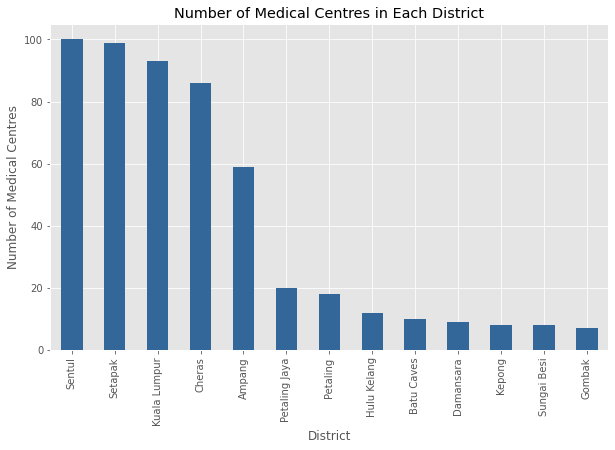

In [59]:
df_h.plot(kind='bar', figsize=(10, 6), rot=90,legend=None,color=(0.2, 0.4, 0.6))

plt.xlabel('District')
plt.ylabel('Number of Medical Centres')
plt.title('Number of Medical Centres in Each District')

*Schools*

In [60]:
df_s = pd.DataFrame(venue_schl_clean,columns=['District','Venue','Label']).set_index(["District","Label"]).count(level="District")
df_s.sort_values(by="Venue",axis=0, ascending=False, inplace=True)
df_s

Venue
District            
Petaling          55
Gombak            53
Kuala Lumpur      53
Cheras            51
Sentul            50
Ampang            48
Hulu Kelang       48
Setapak           48
Kepong            43
Batu Caves        41
Petaling Jaya     41
Damansara         36
Sungai Besi       36

Text(0.5, 1.0, 'Number of Schools in Each District')

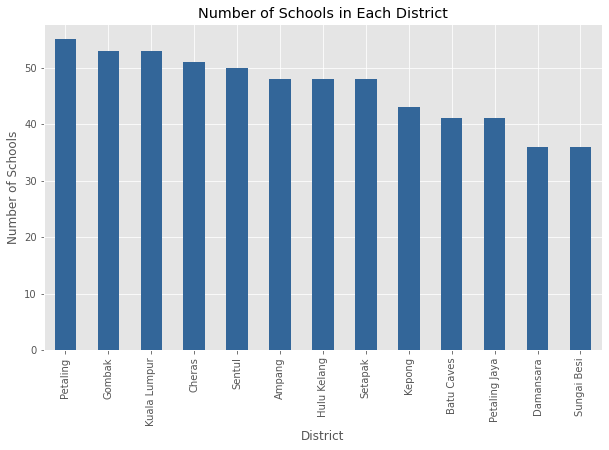

In [61]:
df_s.plot(kind='bar', figsize=(10, 6), rot=90,legend=None,color=(0.2, 0.4, 0.6))

plt.xlabel('District')
plt.ylabel('Number of Schools')
plt.title('Number of Schools in Each District')

In [62]:
venue_schl_clean['Venue_Category'].unique()

array(['School', 'High School', 'Private School', 'Elementary School',
       'Preschool', 'Nursery School', 'Middle School'], dtype=object)

In [63]:
# one hot encoding
s_onehot = pd.get_dummies(venue_schl_clean[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
s_onehot['District'] = venue_schl_clean['District'] 

# move neighborhood column to the first column
fixed_columns = [s_onehot.columns[-1]] + list(s_onehot.columns[:-1])
s_onehot = s_onehot[fixed_columns]

s_onehot.head()

District  Elementary School  High School  Middle School  Nursery School  \
0   Ampang                  0            0              0               0   
1   Ampang                  0            0              0               0   
2   Ampang                  0            0              0               0   
3   Ampang                  0            0              0               0   
4   Ampang                  0            0              0               0   

   Preschool  Private School  School  
0          0               0       1  
1          0               0       1  
2          0               0       1  
3          0               0       1  
4          0               0       1

In [64]:
df_s2 = s_onehot.groupby(by="District").sum()
df_s2.head()

Elementary School  High School  Middle School  Nursery School  \
District                                                                    
Ampang                      7            8              2               3   
Batu Caves                 10           10              0               0   
Cheras                      4           16              2               0   
Damansara                   3            9              1               2   
Gombak                     13           20              2               2   

            Preschool  Private School  School  
District                                       
Ampang              8               1      19  
Batu Caves          0               0      21  
Cheras              1               0      28  
Damansara           0               3      18  
Gombak              1               1      14

In [65]:
df_s2 = s_onehot.groupby(by="District").sum()

df_s2["Elementary School"]=sum([df_s2["Elementary School"],df_s2["Nursery School"],df_s2["Preschool"]])
df_s2.drop(columns=["Nursery School","Preschool"],inplace = True)
df_s2 = df_s2[['Elementary School','Middle School','High School','Private School']]
df_s2.head()

Elementary School  Middle School  High School  Private School
District                                                                 
Ampang                     18              2            8               1
Batu Caves                 10              0           10               0
Cheras                      5              2           16               0
Damansara                   5              1            9               3
Gombak                     16              2           20               1

<AxesSubplot:title={'center':'Type of Schools in each District'}, xlabel='District', ylabel='Number of Schools'>

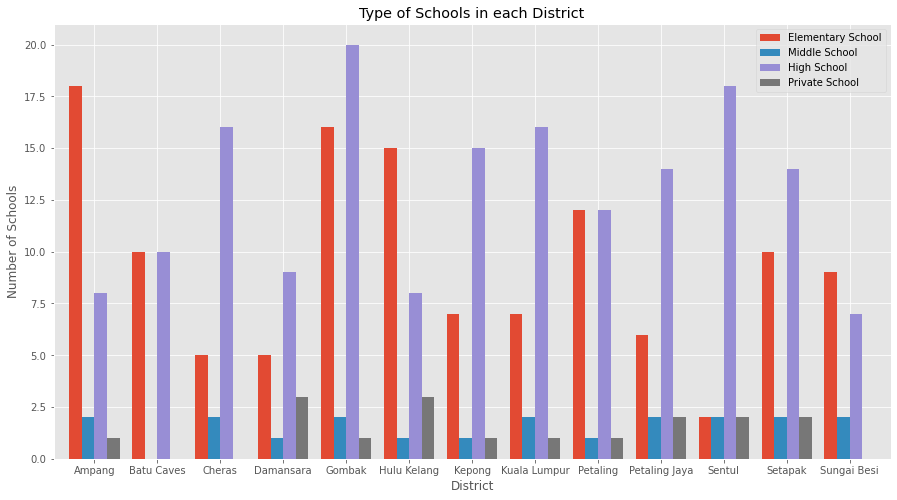

In [66]:
df_s2.plot.bar(title='Type of Schools in each District',xlabel='District',ylabel='Number of Schools',rot=0,figsize=(15,8),width=0.8,sort_columns=True)

*Arts & Entertainment Venues*

In [67]:
df_a = pd.DataFrame(venue_entr_clean,columns=['District','Venue','Label']).set_index(["District","Label"]).count(level="District")
df_a.sort_values(by="Venue",axis=0, ascending=False, inplace=True)
df_a

Venue
District           
Kuala Lumpur     21
Sentul            6
Ampang            5
Setapak           4
Kepong            3
Cheras            2
Hulu Kelang       2
Batu Caves        1
Damansara         1
Petaling          1
Sungai Besi       1

Text(0.5, 1.0, 'Number of Arts & Entertainment Venues in Each District')

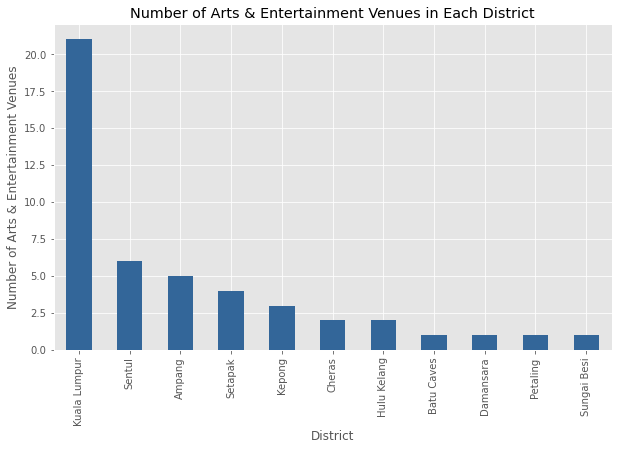

In [68]:
df_a.plot(kind='bar', figsize=(10, 6), rot=90,legend=None,color=(0.2, 0.4, 0.6))

plt.xlabel('District')
plt.ylabel('Number of Arts & Entertainment Venues')
plt.title('Number of Arts & Entertainment Venues in Each District')